# Calculation of control fields for Hadamard gate on single qubit using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.optimize_pulse_unitary function.
The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which is equivalent maximising the fidelity
to an optimal value of 1.

The system in this example is a single qubit in a constant field in z
with a variable control field in x
The target evolution is the Hadamard gate irrespective of global phase

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

An in depth discussion of using methods of this type can be found in [1]

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [16]:
from qutip import Qobj, identity, sigmax, sigmaz,sigmay
from qutip.qip import hadamard_transform
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

example_name = 'Hadamard'


### Defining the physics

The dynamics of the system are governed by the combined Hamiltonian:
H(t) = H_d + sum(u1(t)*Hc1 + u2(t)*Hc2 + ....)
That is the time-dependent Hamiltonian has a constant part (called here the drift) and time vary parts, which are the control Hamiltonians scaled by some functions u_j(t) known as control amplitudes
In this case the drift is simply a rotation about z and the (time-varying) control is a rotation about x
In theory this system is fully controllable (irrespective of global phase) and so any unitary target could be chosen; we have chosen the Hadamard gate.

In [17]:
# Drift Hamiltonian
H_d = sigmaz()
# The (single) control Hamiltonian
H_c = [sigmax()]
# start point for the gate evolution
U_0 = identity(2)
# Target for the gate evolution Hadamard gate
U_targ = sigmay()

### Defining the time evolution parameters

To solve the evolution the control amplitudes are considered constant within piecewise timeslots, hence the evolution during the timeslot can be calculated using U(t_k) = expm(-i*H(t_k)*dt). Combining these for all the timeslots gives the approximation to the evolution from the identity at t=0 to U(T) at the t=evo_time
The number of timeslots and evo_time have to be chosen such that the timeslot durations (dt) are small compared with the dynamics of the system.

In [18]:
# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 10

### Set the conditions which will cause the pulse optimisation to terminate

At each iteration the fidelity of the evolution is tested by comparaing the calculated evolution U(T) with the target U_targ. For unitary systems such as this one this is typically:
f = normalise(overlap(U(T), U_targ))
For details of the normalisation see [1] or the source code.
The maximum fidelity (for a unitary system) calculated this way would be 1, and hence the error is calculated as fid_err = 1 - fidelity. As such the optimisation is considered completed when the fid_err falls below such a target value.

In some cases the optimisation either gets stuck in some local minima, or the fid_err_targ is just not achievable, therefore some limits are set to the time/effort allowed to find a solution.

The algorithm uses gradients to direct its search for the minimum fidelity error. If the sum of all the gradients falls below the min_grad, then it is assumed some local minima has been found.

In [19]:
# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

The control amplitudes must be set to some initial values. Typically these are just random values for each control in each timeslot. These do however result in erratic optimised pulses. For this example, a solution will be found for any initial pulse, and so it can be interesting to look at the other initial pulse alternatives.

In [20]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'

### Give an extension for output files

In [21]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In this step the L-BFGS-B algorithm is invoked. At each iteration the gradient of the fidelity error w.r.t. each control amplitude in each timeslot is calculated using an exact gradient method (see [1]). Using the gradients the algorithm will determine a set of piecewise control amplitudes that reduce the fidelity error. With repeated iterations an approximation of the Hessian matrix (the 2nd order differentials) is calculated, which enables a quasi 2nd order Newton method for finding a minima.  The algorithm continues until one of the termination conditions defined above has been reached.

In [22]:
result = cpo.optimize_pulse_unitary(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Initial state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]
Target state / operator:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.

### Report the results

Firstly the performace statistics are reported, which gives a breadown of the processing times. The times given are those that are associated with calculating the fidelity and the gradients. Any remaining processing time can be assumed to be used by the optimisation algorithm (L-BFGS-B) itself. In this example it can be seen that the majority of time is spent calculating the propagators, i.e. exponentiating the combined Hamiltonian.

The optimised U(T) is reported as the 'final evolution', which is essentially the string representation of the Qobj that holds the full time evolution at the point when the optimisation is terminated.

The key information is in the summary (given) last. Here the final fidelity is reported and the reasonn for termination of the algorithm.

In [23]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.017373
Wall time computing Hamiltonians: 0:00:00.000605 (3.48%)
Wall time computing propagators: 0:00:00.009745 (56.09%)
Wall time computing forward propagation: 0:00:00.000152 (0.87%)
Wall time computing onward propagation: 0:00:00.000153 (0.88%)
Wall time computing gradient: 0:00:00.001260 (7.25%)

**** Iterations and function calls ****
Number of iterations: 6
Number of fidelity function calls: 8
Number of times fidelity is computed: 8
Number of gradient function calls: 7
Number of times gradients are computed: 7
Number of times timeslot evolution is recomputed: 8

**** Control amplitudes ****
Number of control amplitude updates: 7
Mean number of updates per iteration: 1.1666666666666667
Number of timeslot values changed: 70
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 70
Mean number of

### Plot the initial and final amplitudes

Here the (random) starting pulse is plotted along with the pulse (control amplitudes) that was found to produce the target gate evolution to within the specified error.

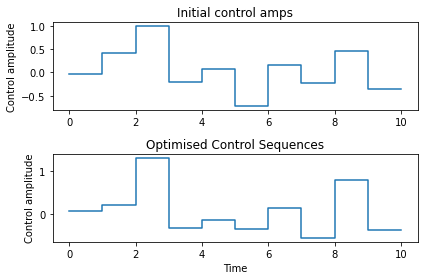

In [24]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
#ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time,
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])),
         where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time,
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])),
         where='post')
plt.tight_layout()
plt.show()

### Versions

In [25]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.18.5
SciPy,1.5.0
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.16.1
Python,"3.8.3 (default, Jul 2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]


### References

[1] Machnes et.al., DYNAMO - Dynamic Framework for Quantum Optimal Control. arXiv.1011.4874